

---



# ***PA - Part II: Advanced Vision Models [Experiments with CIFAR10]*** (45pt)

**Keywords**: Multiclass Image Classification, ResNet, Vision Transformers, CLIP

**CIFAR10**
* The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) database is a large database with images of objects like airplane, bird, cat, dog, etc.
* It contains 70,000 labeled images. Each datapoint is a $32\times 32$ pixels RGB image.
* To provide a realistic problem, we will use the images at this standard resolution of $32\times 32$.

**Agenda**:
* The PA is split into three parts, the first part dealing with miniature models which we will build from scratch, the second part dealing with modern architectures and the bonus third part dealing with training vision models robust to adversarial attacks.
* In this part, we will be moving towards more modern architectures and a more realistic problem, finetuning pretrained model of different architectures on the CIFAR10 dataset and comparing its performance with models trained from scratch (initialized with random weights).
* We will also be evaluating CLIP, which uses an architecture which is a backbone or helper model in most modern LLMs for image analysis and even in image generation models.
* We will be using PyTorch and HuggingFace for loading and reusing complex model architecture.

**Note:**
* Hardware acceleration (GPU) is **highly recommended** for this part as we will be training comparitively larger models!
* If you are running locally, increase the `num_workers` parameter in the dataloaders to speed up computations. As Colab vCPUs have limits, it tends to be slower.
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* Only **add your code** to cells marked with "TODO:" or with "..."
* You should not have to change variable names where provided, but you are free to if required for your implementation.

### **Pre-training and fine-tuning**

* In this part, we want to use modern architectures, namely the **ResNet** and **Vision Transformer**, for classification on the CIFAR10 dataset.
* Instead of trying to train these modern architectures from random weights for our task, we can instead use **pre-trained** models that have already been trained on a large amount of data.
* We can then **fine-tune** these models for our specific tasks.
* ImageNet is one such large-scale dataset (~1.3 million images) that is widely used for pretraining neural network models.
* These pretrained models serve as good initializations for various image-related tasks.
* We compare fine-tuned models and models trained from random initialization to analyze the difference in performance of these approaches.

### ***Setup: Imports and Utils***

In [ ]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  



---



100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]


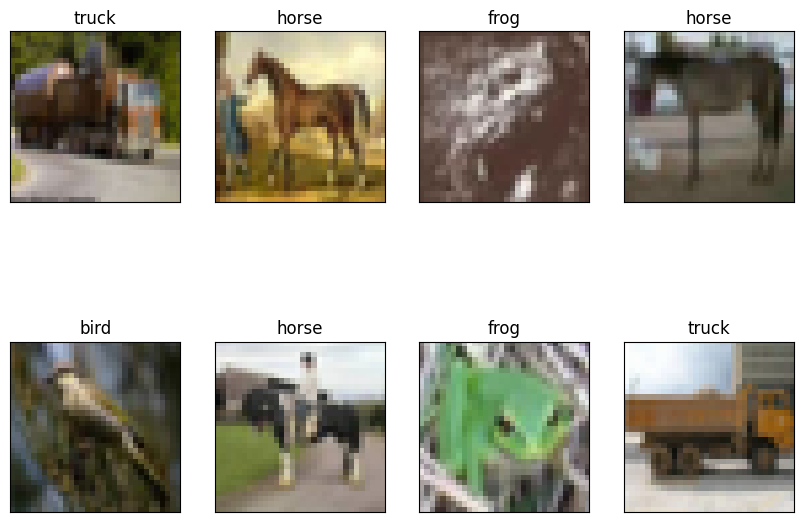

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import transformers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
import timm
import math

batch_size = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unnormalize(img, mean, std):
    return img.mul_(std.reshape(-1, 1, 1)).add_(mean.reshape(-1, 1, 1))

# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        curr_img = images[i]
        curr_img = unnormalize(curr_img, mean=torch.Tensor([0.485, 0.456, 0.406]), std=torch.Tensor([0.229, 0.224, 0.225]))
        plt.imshow(np.transpose(curr_img, (1, 2, 0)))
        plt.title(classes[titles[i]], size=12)
        plt.xticks(())
        plt.yticks(())


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# visualize some of the images of the CIFAR10 dataset
plot_gallery(images[:8], labels[:8], 32, 32, 2, 4)

### *(a) Training framework for CIFAR10* (10pt)

* For the more challenging CIFAR10 dataset, it is more useful to track the training and testing set accuracies during training.
* However, unlike with MNIST and the simple linear models, it is not always possible to load the entire dataset and pass the full batch through the model to compute the accuracy.
* Hence, we need to compute the accuracy in a mini-batch manner in the function `get_accuracy_cifar10`.
    * It takes as input the `model`, a `dataloader` (either for training or test set), and the `batch_size`.
* Following this, implement the training function `train_torch_model_cifar10` (similar to MNIST) but compute and print the training and testing accuracy after every epoch.
    * It should take as input the `model`, `trainloader`, `testloader`, `batch_size`, a predefined `optimizer`, the loss function `criterion`, maximum number of epochs `max_epochs`, and `tolerance`.
* You should be able to use the `train_torch_model` code from Part I by adding support for dataloaders.

In [ ]:
def get_accuracy_cifar10(model, dataloader, batch_size):
    correct = 0
    total = 0

    with torch.no_grad(): # Close the Gradient Calculation
      for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Ensure the tensors to be on the same device
        output = model(X_batch)
        values, predicted_indices = torch.max(output, 1)
        correct += (predicted_indices == y_batch).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    return acc

# Define a function train_torch_model_cifar10
def train_torch_model_cifar10(model, trainloader, testloader, batch_size, optimizer, criterion, max_epochs, tolerance, device='cuda'):
  losses = []
  train_acc = []
  test_acc = []
  prev_loss = float('inf')

  #######
  # 3. move model to device
  model.to(device)

  for epoch in tqdm(range(max_epochs)):
    for idx, (X_train_batch, y_train_batch) in enumerate(trainloader):
      # 3. move mini-batch data to device
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

      # 4. reset gradients
      optimizer.zero_grad()

      # 5. prediction on mini-batch data
      pred = model(X_train_batch)

      # 6. calculate loss
      loss = criterion(pred, y_train_batch)

      # 7. backpropagate loss
      loss.backward()

      # 8. perform a single gradient update step
      optimizer.step()

    train_acc_curr = get_accuracy_cifar10(model, trainloader, batch_size)
    test_acc_curr = get_accuracy_cifar10(model, testloader, batch_size)
    #######
    # log loss every 100th epoch and print every 5000th epoch:
    losses.append((epoch, loss.item()))
    print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    print("Train accuracy:", train_acc_curr)
    print("Test accuracy:", test_acc_curr)
    train_acc.append((epoch, train_acc_curr))
    test_acc.append((epoch, test_acc_curr))

    # break if decrease in loss is less than threshold
    if abs(prev_loss - loss.item()) < tolerance:
      print("Break! Early stopping triggere since the loss is less than threshold.")
      break
    prev_loss = loss.item()

  # return updated model and logged losses
  return model, losses, train_acc, test_acc

### *(b) ResNet* (10pt)

#### #1. Training with random initialization

* Using the defined `train_torch_model_cifar10`, we will first train a model using the ResNet50 architecture from scratch.
* Hyperparameters:
  * Batch size of $100$
  * SGD optimizer with learning rate $0.001$ and momentum $0.9$
  * CE Loss
  * Train the model for a maximum of $15$ epochs.
* Use the `torchvision.models.resnet50` function to define the model and set the arguments such that pretrained weights are not used.
* The default `resnet50` model has 1000 output neurons (since ImageNet1k has 1000 classes) in the last layer while we need only 10 for CIFAR10.

We will also compute the training and testing set accuracies after every epoch and plot them.

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50

model = resnet50(pretrained=False)

model.fc = torch.nn.Linear(model.fc.in_features, 10) # 1000 output neurons -> 10 for CIFAR10

batch_size = 100
# define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
# Set learning rate to lr and also set model parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

max_epochs = 15
tolerance = 1e-4  # Early Stoping Tolerance

model, losses, train_accs, test_accs = train_torch_model_cifar10(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    tolerance=tolerance,
    device=device
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.013981819152832
Train accuracy: 0.35178
Test accuracy: 0.3435
Epoch: 1, Loss: 2.0110676288604736
Train accuracy: 0.43552
Test accuracy: 0.4001
Epoch: 2, Loss: 1.6131242513656616
Train accuracy: 0.47528
Test accuracy: 0.4273
Epoch: 3, Loss: 1.469616413116455
Train accuracy: 0.51966
Test accuracy: 0.4522
Epoch: 4, Loss: 1.641402244567871
Train accuracy: 0.5681
Test accuracy: 0.4763
Epoch: 5, Loss: 1.2013987302780151
Train accuracy: 0.59684
Test accuracy: 0.4821
Epoch: 6, Loss: 1.5383262634277344
Train accuracy: 0.632
Test accuracy: 0.4932
Epoch: 7, Loss: 0.9974661469459534
Train accuracy: 0.66666
Test accuracy: 0.5
Epoch: 8, Loss: 1.1959586143493652
Train accuracy: 0.6953
Test accuracy: 0.504
Epoch: 9, Loss: 1.1786892414093018
Train accuracy: 0.73562
Test accuracy: 0.511
Epoch: 10, Loss: 0.7713893055915833
Train accuracy: 0.76896
Test accuracy: 0.5084
Epoch: 11, Loss: 0.9026442766189575
Train accuracy: 0.77842
Test accuracy: 0.5107
Epoch: 12, Loss: 0.8003696203231812
Tr

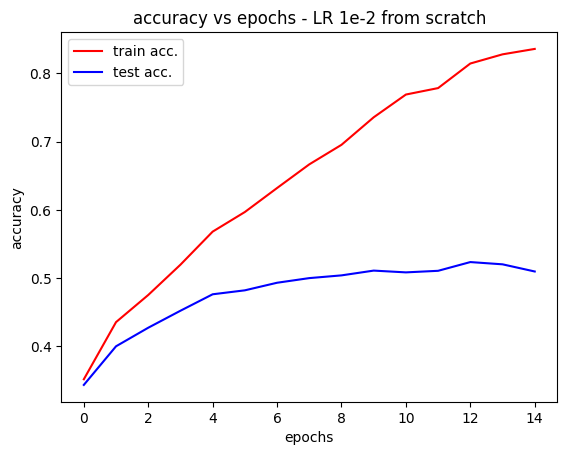

In [ ]:
plt.plot([x[0] for x in train_accs],[x[1] for x in train_accs], 'r', label='train acc.')
plt.plot([x[0] for x in test_accs],[x[1] for x in test_accs], 'b', label='test acc.')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs - LR 1e-2 from scratch')
plt.legend()

#### #2. Training with pretrained initialization

* Using the defined `train_torch_model_cifar10`, we will now train a ResNet50 model initialized from an ImageNet pretrained model.
* We will use the same hyperparameters as the previous part #2.1.
  * Batch size of $100$
  * SGD optimizer with learning rate $0.001$ and momentum $0.9$
  * CE Loss
  * Train the model for a maximum of $15$ epochs.
* We will use the same `torchvision.models.resnet50` function to define the model, but set the arguments such that ImageNet1k-v2 pretrained weights are used for initialization.

We will also compute and plot the training and testing set accuracies after every epoch.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model.fc = torch.nn.Linear(model.fc.in_features, 10)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

max_epochs = 15
tolerance = 1e-4  # Early Stoping Tolerance

batch_size = 100

model, losses, train_accs, test_accs = train_torch_model_cifar10(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    tolerance=tolerance,
    device=device
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.8774340748786926
Train accuracy: 0.71682
Test accuracy: 0.6827
Epoch: 1, Loss: 0.6398633718490601
Train accuracy: 0.811
Test accuracy: 0.7517
Epoch: 2, Loss: 0.5418192744255066
Train accuracy: 0.86444
Test accuracy: 0.7854
Epoch: 3, Loss: 0.41011062264442444
Train accuracy: 0.89656
Test accuracy: 0.7958
Epoch: 4, Loss: 0.2765777111053467
Train accuracy: 0.9249
Test accuracy: 0.8076
Epoch: 5, Loss: 0.1497117131948471
Train accuracy: 0.9394
Test accuracy: 0.8133
Epoch: 6, Loss: 0.20882584154605865
Train accuracy: 0.95692
Test accuracy: 0.8159
Epoch: 7, Loss: 0.0915210172533989
Train accuracy: 0.96822
Test accuracy: 0.8216
Epoch: 8, Loss: 0.19692260026931763
Train accuracy: 0.97458
Test accuracy: 0.82
Epoch: 9, Loss: 0.1939532458782196
Train accuracy: 0.98092
Test accuracy: 0.8222
Epoch: 10, Loss: 0.05898956209421158
Train accuracy: 0.983
Test accuracy: 0.8248
Epoch: 11, Loss: 0.03971254453063011
Train accuracy: 0.98588
Test accuracy: 0.8261
Epoch: 12, Loss: 0.0381840169

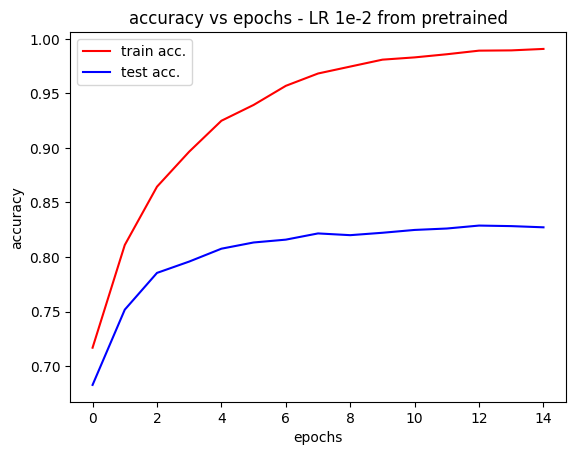

In [ ]:
plt.plot([x[0] for x in train_accs],[x[1] for x in train_accs], 'r', label='train acc.')
plt.plot([x[0] for x in test_accs],[x[1] for x in test_accs], 'b', label='test acc.')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs - LR 1e-2 from pretrained')
plt.legend()

### *(c) Vision Transformer* (https://arxiv.org/abs/2010.11929) (10pt)


* This architecture was proposed following the popularization of transformer models for language modeling.
* Vision Transformers can be considered a variation of transformers with image inputs.
* The images are divided as 16x16 patches (the size varies with different models) and a sequence of these patches is passed as the input to the transformer model.


First, we modify the shape of the images to be 224x224 as this is what the ViT model we are using expects.

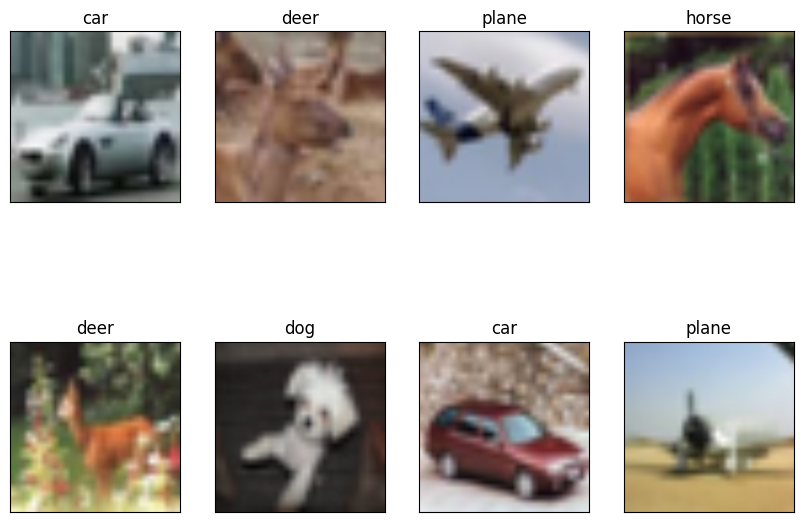

In [ ]:
vit_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

vit_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=vit_transform)

vit_trainloader = torch.utils.data.DataLoader(vit_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

vit_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=vit_transform)
vit_testloader = torch.utils.data.DataLoader(vit_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataiter = iter(vit_trainloader)
vit_images, vit_labels = next(dataiter)

# visualize some of the images of the CIFAR10 dataset
plot_gallery(vit_images[:8], vit_labels[:8], 32, 32, 2, 4)

#### #1. Training with random initialization

* Similarly, now we will use the `train_torch_model_cifar10` function to train a Classifier using the Vision Transformer Architecture
* Hyperparameters:
  * Batch size of $100$
  * SGD optimizer with learning rate $0.001$ and momentum $0.9$
  * CE Loss
  * Train the model for a maximum of $7$ epochs as training this model is slower than ResNet50.
* Use the `timm/efficientvit_m1.r224_in1k` model either using the `timm` library. We choose this model due to its small number of parameters (3M) which make it easy to train and experiment with.
* By setting the `num_classes` argument, we can customise the number of required classes which is 10, in the case of CIFAR10.



We will also compute the training and testing set accuracies after every epoch and plot them.

Note: This function takes approx 15-30 minutes to run. Ensure it works on a non-GPU runtime first to ensure you don't exhaust resources.

In [ ]:
import torch.nn as nn
import timm

model = timm.create_model('efficientvit_m1.r224_in1k', pretrained = False, num_classes = 10)

# define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
# Set learning rate to lr and also set model parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

max_epochs = 7
tolerance = 1e-4  # Early Stoping Tolerance

batch_size = 100

model, losses, train_accs, test_accs = train_torch_model_cifar10(
    model=model,
    trainloader=vit_trainloader,
    testloader=vit_testloader,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    tolerance=tolerance,
    device=device
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.6083298921585083
Train accuracy: 0.507
Test accuracy: 0.4875
Epoch: 1, Loss: 1.2575690746307373
Train accuracy: 0.58124
Test accuracy: 0.5465
Epoch: 2, Loss: 1.1638212203979492
Train accuracy: 0.63348
Test accuracy: 0.5796
Epoch: 3, Loss: 0.8798545002937317
Train accuracy: 0.68112
Test accuracy: 0.6084
Epoch: 4, Loss: 0.8386316895484924
Train accuracy: 0.72212
Test accuracy: 0.632
Epoch: 5, Loss: 0.5688455700874329
Train accuracy: 0.75978
Test accuracy: 0.6419
Epoch: 6, Loss: 0.6319459676742554
Train accuracy: 0.7858
Test accuracy: 0.6434


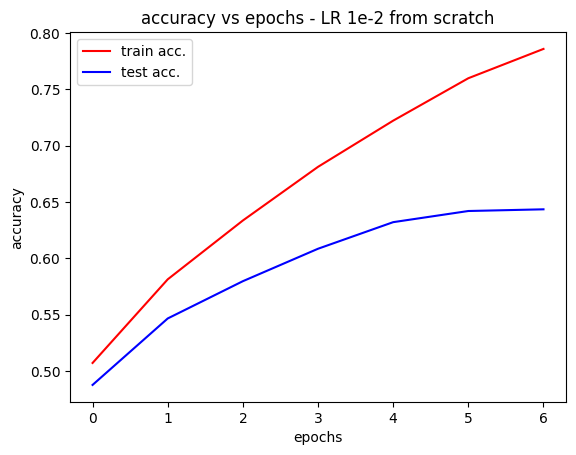

In [ ]:
plt.plot([x[0] for x in train_accs],[x[1] for x in train_accs], 'r', label='train acc.')
plt.plot([x[0] for x in test_accs],[x[1] for x in test_accs], 'b', label='test acc.')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs - LR 1e-2 from scratch')
plt.legend()

#### #2. Training with pretrained initialization


* We will use the same `timm/efficientvit_m1.r224_in1k` model but we will use its pretrained weights on ImageNet using the `pretained` parameter.
* We will use the same hyperparameters as the previous part #3.1.
  * Batch size of $100$
  * SGD optimizer with learning rate $0.001$ and momentum $0.9$
  * CE Loss
  * Train the model for a maximum of $7$ epochs.

We will also compute and plot the training and testing set accuracies after every epoch.

Note: This function takes approx 15-30 minutes to run. Ensure it works on a non-GPU runtime first to ensure you don't exhaust resources.

In [ ]:
import torch.nn as nn
import timm

model = timm.create_model('efficientvit_m1.r224_in1k', pretrained = True, num_classes = 10)

# define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
# Set learning rate to lr and also set model parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

max_epochs = 7
tolerance = 1e-4  # Early Stoping Tolerance

batch_size = 100

model, losses, train_accs, test_accs = train_torch_model_cifar10(
    model=model,
    trainloader=vit_trainloader,
    testloader=vit_testloader,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    tolerance=tolerance,
    device=device
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.2248324155807495
Train accuracy: 0.601
Test accuracy: 0.5986
Epoch: 1, Loss: 0.7399659752845764
Train accuracy: 0.77216
Test accuracy: 0.7673
Epoch: 2, Loss: 0.5494275093078613
Train accuracy: 0.82918
Test accuracy: 0.8175
Epoch: 3, Loss: 0.42958521842956543
Train accuracy: 0.86558
Test accuracy: 0.8519
Epoch: 4, Loss: 0.40067949891090393
Train accuracy: 0.8862
Test accuracy: 0.8706
Epoch: 5, Loss: 0.27602532505989075
Train accuracy: 0.90172
Test accuracy: 0.8878
Epoch: 6, Loss: 0.3236459493637085
Train accuracy: 0.89762
Test accuracy: 0.8742


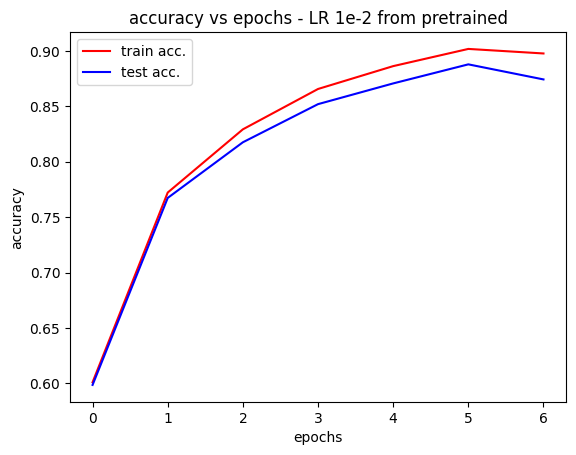

In [ ]:
plt.plot([x[0] for x in train_accs],[x[1] for x in train_accs], 'r', label='train acc.')
plt.plot([x[0] for x in test_accs],[x[1] for x in test_accs], 'b', label='test acc.')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs - LR 1e-2 from pretrained')
plt.legend()

### *(d) CLIP (Contrastive Language-Image Pretraining - [Paper](https://arxiv.org/abs/2103.00020) )* (10pt)

* CLIP jointly trains a text-encoder and image-encoder on images and text captions.
* CLIP generates representations (vector embeddings) of both the text and image such that they lie in the same vector space.
* CLIP optimizes the embeddings such that the image and captions are closer in the vector space if they correspond to each other and farther if they do not.
* The image-encoder is a pluggable model - usually a ResNet or Vision Transformer. We will use both.
* For this section, we will not be doing any pretraining or finetuning, rather just loading and evaluating it on CIFAR10 test-set (zero-shot image classification).

Note: This is a simplified explanation. You can read the paper if you need more details. However, this is not essential for the assignment.

In [ ]:
import open_clip

captions = [f"a photo of a {label}" for label in classes]

clip_testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False)

Note: We will use the `open_clip` package to run CLIP. You can refer the documentation at https://github.com/mlfoundations/open_clip

We define a new testset for CLIP since it uses PIL images as inputs and does not require tensor conversion

Note: We convert the class labels to a caption format which works better with CLIP.

#### #1. Predict and accuracy function

* Write the `clip_predict` function that takes in the CLIP `model`, a list of processed `images`, tokenized `texts` and encodes the texts and images.
* The function should then use the encoded features to find and return the predicted label for each of the `images`.

* Complete the `clip_accuracy` function takes in the CLIP `model`, the CLIP image `processor` and text/caption `tokenizer` and torchvision image `dataset` as input
* The function processes the images and texts into vectors in batch-form and uses the `clip_predict` predictions to calculate accuracy over the `dataset`

In [ ]:
def clip_predict(model, images, texts):

  with torch.no_grad():
      # get the image and text vectors using the model's encode functions
      image_features = model.encode_image(images)
      text_features = model.encode_text(texts)

      # normalize the image and text vectors
      image_features_n = image_features / image_features.norm(dim=-1, keepdim=True) # Normalized into a unit vector by dividing a L2 Norm
      text_features_n = text_features / text_features.norm(dim=-1, keepdim=True)

      # find the cosine similarity between the image and text vectors and softmax them to get the probabilities
      logits = image_features @ text_features.T # Original Score: shape (batch_size, num_classes)
      probs = nn.functional.softmax(logits, dim=-1)

      # calculate predicted label index
      preds = torch.argmax(probs, dim=-1)

  #return predicted labels
  return preds

def clip_accuracy(model, processor, tokenizer, dataset, batch_size, captions=captions):

  # process the text using the tokenizer
  texts = tokenizer(captions).to(device) # caption -> tensor

  #calculate the number of batches
  number_of_batches = len(dataset) // batch_size

  correct = 0

  for i in range(number_of_batches):

    # define start and end indices
    start = i * batch_size
    end = start + batch_size

    # process the images in the batch using the processor
    original_images = [dataset[j][0] for j in range(start, end)]
    images = torch.stack([processor(img) for img in original_images]).to(device) # Process images in the batch into tensors

    # get the labels
    labels = torch.tensor([dataset[j][1] for j in range(start, end)]).to(device) # .to(device): Ensure preds and labels are on the same device

    # use the clip_predict function to
    preds = clip_predict(model, images, texts)
    correct += (preds == labels).sum().item()

  return correct / len(dataset)

#### #2. CLIP Model using Vision Transformer

* Use the `open_clip.create_model_and_transforms` function from the `open_clip` library to load the model and image processor.
* Pass the `ViT-B-32` as the model and `openai` as the pretrained weights to use.
* Use the `open_clip.get_tokenizer` with the same model name to get the tokenizer.

In [ ]:
model, _, processor = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

* Call the `clip_accuracy` function with appropriate parameters. Optionally, you can pass in custom images and captions to the `clip_predict` function to see interesting outputs.

Note: This function takes approx 15-30 minutes to run. Ensure it works on a non-GPU runtime first to ensure you don't exhaust resources.

In [ ]:
model = model.to(device)

acc = clip_accuracy(
    model=model,
    processor = processor,
    tokenizer = tokenizer,
    dataset = clip_testset,
    batch_size = 100)

print(f"CLIP Zero-shot Accuracy on CIFAR-10 using Vision Transformer: {acc:.4f}")

CLIP Zero-shot Accuracy on CIFAR-10 using Vision Transformer: 0.8281


Pass in custom images and see the outputs:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving myApple.jpg to myApple.jpg


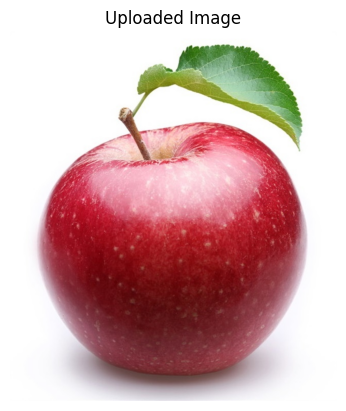

In [ ]:
from PIL import Image

# Upload an image of an apple
img = Image.open("myApple.jpg").convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

In [ ]:
# Define the prompt for the uploaded image
prompts = ["a photo of a banana", "a photo of a orange", "a photo of an peach", "a photo of an apple"]

# Tokenize prompts and pass it to the device
text_inputs = tokenizer(prompts).to(device)

# Process the image into tensor
img_tensor = processor(img).unsqueeze(0).to(device)

# Do prediction
pred = clip_predict(model, img_tensor, text_inputs)

# Out the predicted class of the uploaded image
print("Predicted class:", prompts[pred.item()])

Predicted class: a photo of an apple


#### #3. CLIP Model using Resnet50

* We are now going to use a ResNet50 based CLIP-model instead of Vision Transformer a
* Use the same code as in #2 except the model name should be `RN50`

In [ ]:
model, _, processor = open_clip.create_model_and_transforms("RN50", pretrained="openai")
tokenizer = open_clip.get_tokenizer('RN50')

open_clip_model.safetensors:   0%|          | 0.00/408M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Note: This function takes approx 15-30 minutes to run. Ensure it works on a non-GPU runtime first to ensure you don't exhaust resources.

In [ ]:
model = model.to(device)

acc = clip_accuracy(
    model=model,
    processor = processor,
    tokenizer = tokenizer,
    dataset = clip_testset,
    batch_size = 100)

print(f"CLIP Zero-shot Accuracy on CIFAR-10 using ResNet50: {acc:.4f}")

CLIP Zero-shot Accuracy on CIFAR-10 using ResNet50: 0.3522


* Call the `clip_predict` function with appropriate parameters. Optionally, you can pass in custom captions to see interesting outputs using CLIP.

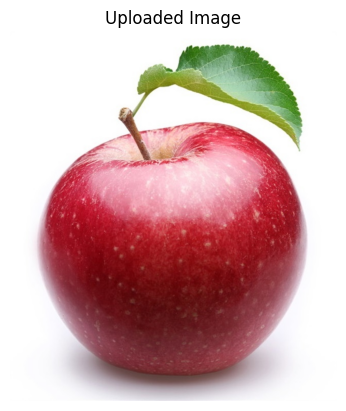

In [ ]:
from PIL import Image

# Upload an image of an apple
img = Image.open("myApple.jpg").convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

In [ ]:
# Define the prompt for the uploaded image
prompts = ["a photo of a banana", "a photo of a orange", "a photo of an peach", "a photo of an apple"]

# Tokenize prompts and pass it to the device
text_inputs = tokenizer(prompts).to(device)

# Process the image into tensor
img_tensor = processor(img).unsqueeze(0).to(device)

# Do prediction
pred = clip_predict(model, img_tensor, text_inputs)

# Out the predicted class of the uploaded image
print("Predicted class:", prompts[pred.item()])

Predicted class: a photo of a banana


### *(e) Analysis* (5pt)

(Two Questions)

**# Effect of pretraining**

**Effect:** Pretraining significantly **improves both training and test performance.** It enables models to converge faster and achieve higher accuracy by starting from more generalizable feature representations learned from some large-scale datasets.

**Experimental Evidence:**

- After pretraining, all models show substantial accuracy gains within the first few epochs. (Based on the plot)

- CLIP (15 epochs):

  - Final Loss drops dramatically (from 0.72 → 0.02)

  - Train Accuracy: 84% → 99%

  - Test Accuracy: 51% → 83%

- Vision Transformer (7 epochs):

  - Final Loss drops from 0.63 → 0.32

  - Train Accuracy: 79% → 90%

  - Test Accuracy: 64% → 87%

**Possible Reasons:** Pretraining equips the model with prior knowledge about general visual patterns, which reduces the reliance on large labeled target datasets like CIFAR-10.


**# Effect of architecture** (ResNet v/s ViT v/s CLIP)

**Effect:** In general, **Vision Transformers (ViT) outperform ResNet** because of their global receptive field and attention mechanisms, and **CLIP-based models, particularly CLIP+ViT**, has the strongest performance due to both pretraining and architectural advantages.

**Experimental Evidence:**

- ViT vs CLIP:

  - CLIP+ViT shows strong performance on both classification and generalization tasks.

    - CLIP Zero-shot Accuracy on CIFAR-10 with ViT: 0.8281

    - Correctly identifies unseen inputs (e.g., correctly classifies an image of an apple).

  - CLIP+ResNet performs significantly worse in zero-shot settings:

    - CLIP Zero-shot Accuracy on CIFAR-10 with ResNet50: 0.3522

    - Misclassifies the apple image as a banana.

**Possible Reasons:**

- ViT uses transformer architecture, and the self-attention algorithms is useful on complex datasets. While ResNet is a convolutional model, whose convolutional layers only focus on local patterns in the image, so it may underperform on tasks like zero-shot classification that need deeper semantic understanding.

- CLIP+ViT combines the strength of pretrained multimodal learning with transformer architecture, allowing it to generalize better and better align visual features with language descriptions.

- CLIP+ResNet does benefit from pretraining, but is likely limited by the architectural limitations of convolutional features in aligning with language representations, thus resulting the low zero-shot accuracy.
